In [1]:
import sys
sys.path.append('../src')
import importlib
import module2graph2
importlib.reload(module2graph2)

import torch
import numpy as np

In [102]:
"""
Функция типа 
W1x + W2x
"""
class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.feed1 = torch.nn.Sequential(torch.nn.Linear(5, 2))
        self.feed2 = torch.nn.Sequential(torch.nn.Linear(5, 2))
        
    def forward(self, x, intermediate = False):
        f1 = self.feed1(x)
        f2 = self.feed2(x)
        return f1+f2/2 
    
rs = np.random.RandomState(42)
x = torch.tensor(rs.randn(100, 5).astype(np.float32))
y = 1*(x.sum(1) >= 0)
(y*1.0).mean()

tensor(0.5200)

In [103]:
module = MyModule()
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(module.parameters())
for _ in range(1000):
    opt.zero_grad()
    loss = crit(module(x), y)
    loss.backward()
    opt.step()
    
    
print ('Accuracy')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())

print ('Only Feed1')
print ((1.0*torch.eq(y, module.feed1(x).argmax(1))).mean())

print ('Only Feed2')
print ((1.0*torch.eq(y, module.feed2(x).argmax(1))).mean())

Accuracy
tensor(1.)
Only Feed1
tensor(0.9200)
Only Feed2
tensor(0.9000)


In [104]:
importlib.reload(module2graph2)
from torch.fx import symbolic_trace
traced_graph = symbolic_trace(module)
module2graph2.make_gamma_hooks(module, traced_graph, lambda: module2graph2.SigmoidGamma(100.0))

In [105]:
module

MyModule(
  (feed1): Sequential(
    (0): Linear(
      in_features=5, out_features=2, bias=True
      (gamma_feed1_0): SigmoidGamma()
    )
  )
  (feed2): Sequential(
    (0): Linear(
      in_features=5, out_features=2, bias=True
      (gamma_feed2_0): SigmoidGamma()
    )
  )
)

In [106]:
"""
Здесь ничего нет, т.к. модуль еще не вызывался
"""
module.intermediate

{}

In [107]:
print ('Accuracy')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())

print ('Only Feed1')
module.feed1[0].gamma_feed1_0.param.data -=999
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))

module.feed1[0].gamma_feed1_0.param.data +=999

print ('Only Feed2')
module.feed2[0].gamma_feed2_0.param.data -=999
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))
module.feed2[0].gamma_feed2_0.param.data +=999


Accuracy
tensor(1.)
Only Feed1
tensor(0.9000)
magnitudes tensor(0., grad_fn=<AbsBackward0>) tensor(54.0638, grad_fn=<AbsBackward0>)
Only Feed2
tensor(0.9200)
magnitudes tensor(27.4526, grad_fn=<AbsBackward0>) tensor(0., grad_fn=<AbsBackward0>)


In [108]:
module.intermediate

{'feed1_0': tensor([[-1.1362e+00,  1.2952e+00],
         [-7.7077e-01,  1.7613e+00],
         [ 2.4852e+00, -1.6794e+00],
         [ 1.9412e+00, -1.5921e+00],
         [ 6.3927e-01,  7.1144e-01],
         [ 8.7965e-01, -3.5825e-01],
         [-3.1406e-01,  1.1910e+00],
         [ 1.6693e+00, -1.8633e+00],
         [ 6.5365e-01,  1.9467e-03],
         [ 9.9947e-01, -8.3484e-01],
         [-7.4912e-01,  7.5472e-01],
         [-7.0983e-01,  1.0712e+00],
         [ 8.6948e-01, -6.1119e-01],
         [-6.7679e-01,  1.6713e+00],
         [-3.0624e-01,  3.6905e-01],
         [ 7.3999e-01, -2.9298e-01],
         [ 3.3443e-01,  6.4014e-01],
         [-2.0740e-01,  8.6445e-01],
         [ 1.5905e-01,  2.7197e-01],
         [ 5.6881e-01, -6.0903e-01],
         [ 1.4689e+00, -1.5192e+00],
         [-1.1290e+00,  1.9175e+00],
         [-5.9773e-01, -6.1244e-01],
         [-9.3380e-01,  6.2806e-01],
         [ 2.2649e-01,  1.2412e+00],
         [-1.5483e-01,  8.7416e-01],
         [ 1.1372e+00, -1.8

In [118]:
"""
Обнуляем обучение модуля
"""

module.gammas[0].data *= 0

module.gammas[1].data *= 0

module.feed1[0].weight.data *= 0

module.feed1[0].weight.data += 0.124
module.feed2[0].weight.data *= 0

print ('Accuracy')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())

print ('Only Feed1')
#module.feed1[0].gamma_feed1_0.param.data -=999
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))

#module.feed1[0].gamma_feed1_0.param.data +=999

print ('Only Feed2')
#module.feed2[0].gamma_feed2_0.param.data -=999
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))
#module.feed2[0].gamma_feed2_0.param.data +=999


Accuracy
tensor(0.5200)
Only Feed1
tensor(0.5200)
magnitudes tensor(18.1900, grad_fn=<AbsBackward0>) tensor(22.9919, grad_fn=<AbsBackward0>)
Only Feed2
tensor(0.5200)
magnitudes tensor(18.1900, grad_fn=<AbsBackward0>) tensor(22.9919, grad_fn=<AbsBackward0>)


In [119]:
"""
Запускаем dartslike
"""
import dartslike
importlib.reload(dartslike)
trainer = dartslike.DartsLikeTrainer(module)
trainer.train_loop([(x, y)], [(x,y)], [(x,y)], 99999, 100, 1e-3, 1e-3, 'cpu', 1e-10)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[]

In [120]:
print ('Accuracy')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())

print ('Only Feed1')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))


print ('Only Feed2')
print ((1.0*torch.eq(y, module(x).argmax(1))).mean())
print ('magnitudes', abs(module.feed1(x).sum()), abs(module.feed2(x).sum()))


Accuracy
tensor(0.9300)
Only Feed1
tensor(0.9300)
magnitudes tensor(19.3853, grad_fn=<AbsBackward0>) tensor(24.4985, grad_fn=<AbsBackward0>)
Only Feed2
tensor(0.9300)
magnitudes tensor(19.3853, grad_fn=<AbsBackward0>) tensor(24.4985, grad_fn=<AbsBackward0>)


In [121]:
module.feed1[0].weight, module.feed2[0].weight


(Parameter containing:
 tensor([[0.0267, 0.0263, 0.0269, 0.0269, 0.0277],
         [0.2213, 0.2217, 0.2211, 0.2211, 0.2203]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0973, -0.0977, -0.0971, -0.0971, -0.0963],
         [ 0.0973,  0.0977,  0.0971,  0.0971,  0.0963]], requires_grad=True))

In [122]:
module.feed1[0].bias, module.feed2[0].bias

(Parameter containing:
 tensor([0.0057, 0.3496], requires_grad=True),
 Parameter containing:
 tensor([-0.0306, -0.4292], requires_grad=True))

In [123]:
module.gammas

[Parameter containing:
 tensor(0.1316, requires_grad=True),
 Parameter containing:
 tensor(0.1312, requires_grad=True)]

# Построение и визуализация графа

In [155]:
class MyModule2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.feed1 = torch.nn.Sequential(torch.nn.Linear(5, 2))
        self.feed2 = torch.nn.Sequential(torch.nn.Linear(2, 2))
        
    def forward(self, x, intermediate = False):
        f1 = self.feed1(x)
        f2 = self.feed2(f1)
        return f2
    
module = MyModule2()
traced_graph = symbolic_trace(module)


importlib.reload(module2graph2)
module2graph2.make_graph_description(traced_graph)


x x
feed1_0 feed1 0


{'feed1.0': ['x'], 'feed2.0': ['feed1.0']}

x x
feed1_0 feed1 0


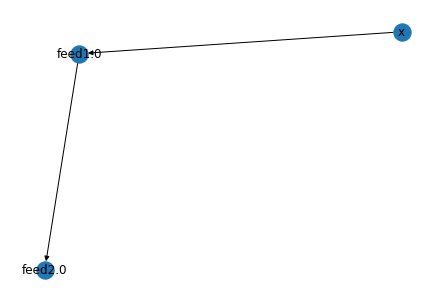

In [156]:
import matplotlib.pylab as plt
%matplotlib inline
import networkx
networkx.draw(module2graph2.networkx_plot_graph(traced_graph), with_labels=True)


# смотрим на T5

In [2]:
from transformers.utils.fx import symbolic_trace as tr_symbolic_trace

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [4]:
tokens = tokenizer(["""My name is Wolfgang and I live in Berlin"""], return_tensors='pt')
out = model.generate(**tokens)
tokenizer.decode(out[0])

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'<pad> Mein Name mein Wolfgang Wolfgang und ich wohne in Berlin.</s>'

In [176]:
traced = tr_symbolic_trace(model)
module2graph2.make_gamma_hooks(model, traced, lambda: module2graph2.Gamma(1.0))

In [177]:
tokens = tokenizer(["""My name is Wolfgang and I live in Berlin"""], return_tensors='pt')
out = model.generate(**tokens)
tokenizer.decode(out[0])

'<pad> Mein Name mein Wolfgang Wolfgang und ich wohne in Berlin.</s>'

In [183]:
for id, g in enumerate(model.gammas):
    g.data *= 0
    tokens = tokenizer(["""My name is Wolfgang and I live in Berlin"""], return_tensors='pt')
    out = model.generate(**tokens)
    print (id, tokenizer.decode(out[0]))
    g.data += 1

    

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0 <pad> Mein Name ist Wolfgang Wolfgang und ich wohn mit Wolfgang Wolfgang und ich wohn in
1 <pad> Mein Name ist Wolfgang Wolfgang und ich wohne in Berlin.</s>
2 <pad> Mein Name Mein Wolfgang Wolfgang und ich wohn mit Wolfgang Wolfgang.</s>
3 <pad> Mein Name ist Wolfgang Wolfgang und ich wohn in Berlin.</s>
4 <pad> Mein Name Mein Name ist Wolfgang Wolfgang und ich wohn in Berlin.</s>
5 <pad> Mein Name ist Wolfgang und ich wohne in Berlin.</s>
6 <pad> Mein Name mein mein Name ist Wolfgang und ich wohne in Berlin.</s>
7 <pad> Mein Name ist Wolfgang Wolfgang und ich sprech ich. Wolfgang Wolfgang.</s>
8 <pad> Mein Name mein Wolfgang Wolfgang und ich wohn mit Wolfgang in Berlin.</s>
9 <pad> Mein Name ist Wolfgang Wolfgang und ich wohne in Berlin.</s>
10 <pad> Mein Name mein Name Wolfgang Wolfgang und ich wohn.</s>
11 <pad> Mein Name mein Wolfgang Wolfgang und ich wohne in Berlin.</s>
12 <pad> Mein Name mein Wolfgang Wolfgang und ich wohnsitz in Berlin.</s>
13 <pad> Mein Name mein Wolfgang W

109 <pad> Mein Name ist Wolfgang Wolfgang und ich wohne in Berlin.</s>
110 <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
111 <pad> Mein Name ist Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang Wolfgang
112 <pad> Mein Name ist Wolfgang Wolfgang und ich lebe in Berlin.</s>
113 <pad> Mein Name mein Name ist Wolfgang Wolfgang und ich wohne in Berlin.</s>
114 <pad> Mein Name ist Wolfgang und ich lebe in Berlin.</s>
115 <pad> Mein Name Wolfgang Wolfgang und ich wohn in Berlin.</s>
116 <pad> Mein Name mein Wolfgang Wolfgang und ich wohn mit Wolfgang Wolfgang und ich wohne
117 <pad> Mein Name mein mein Name ist Wolfgang und ich wohne in Berlin.</s>
118 <pad> Mein Name ist Wolfgang und ich wohne in Berlin.</s>
119 <pad> Mein Name Wolfgang Wolfgang und ich wohn in Berlin.</s>
120 <pad> Mein Name ist Wolfgang Wolfgang und ich wohne in Berlin.</s>
121 <pad> 

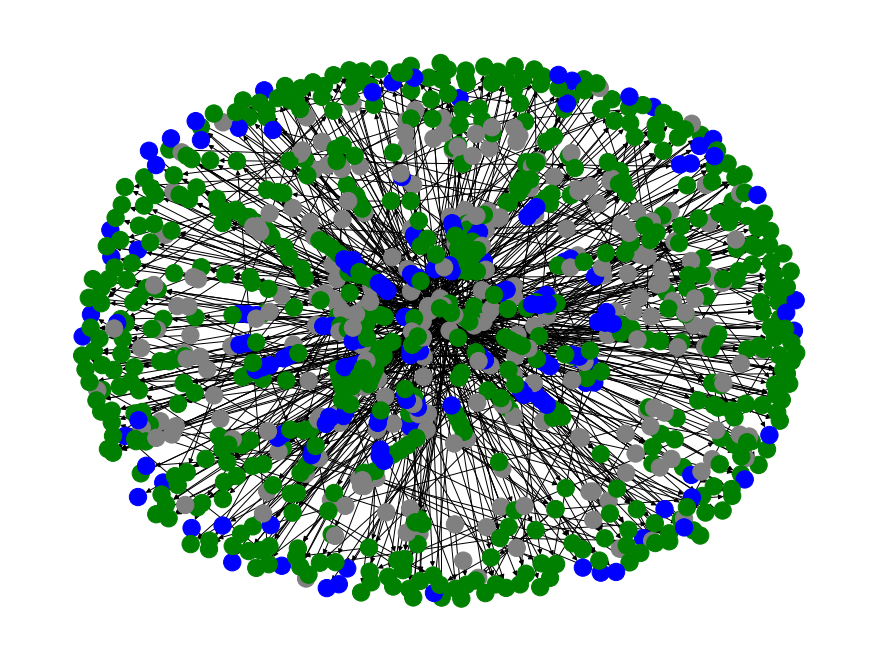

In [209]:
import matplotlib.pylab as plt
%matplotlib inline
import networkx
importlib.reload(module2graph2)
plt.rcParams['figure.figsize'] = (12, 9)
g, colors = module2graph2.networkx_plot_graph(traced, operations=['call_module', 'call_function'])
networkx.draw(g, node_color=colors, with_labels=False)


In [221]:
len(list(networkx.connected_components(g.to_undirected()))) # основной набор операций - в первой компоненте

3

In [246]:
len(list(networkx.bridges(g.to_undirected()))), len(g.edges)

(383, 1396)

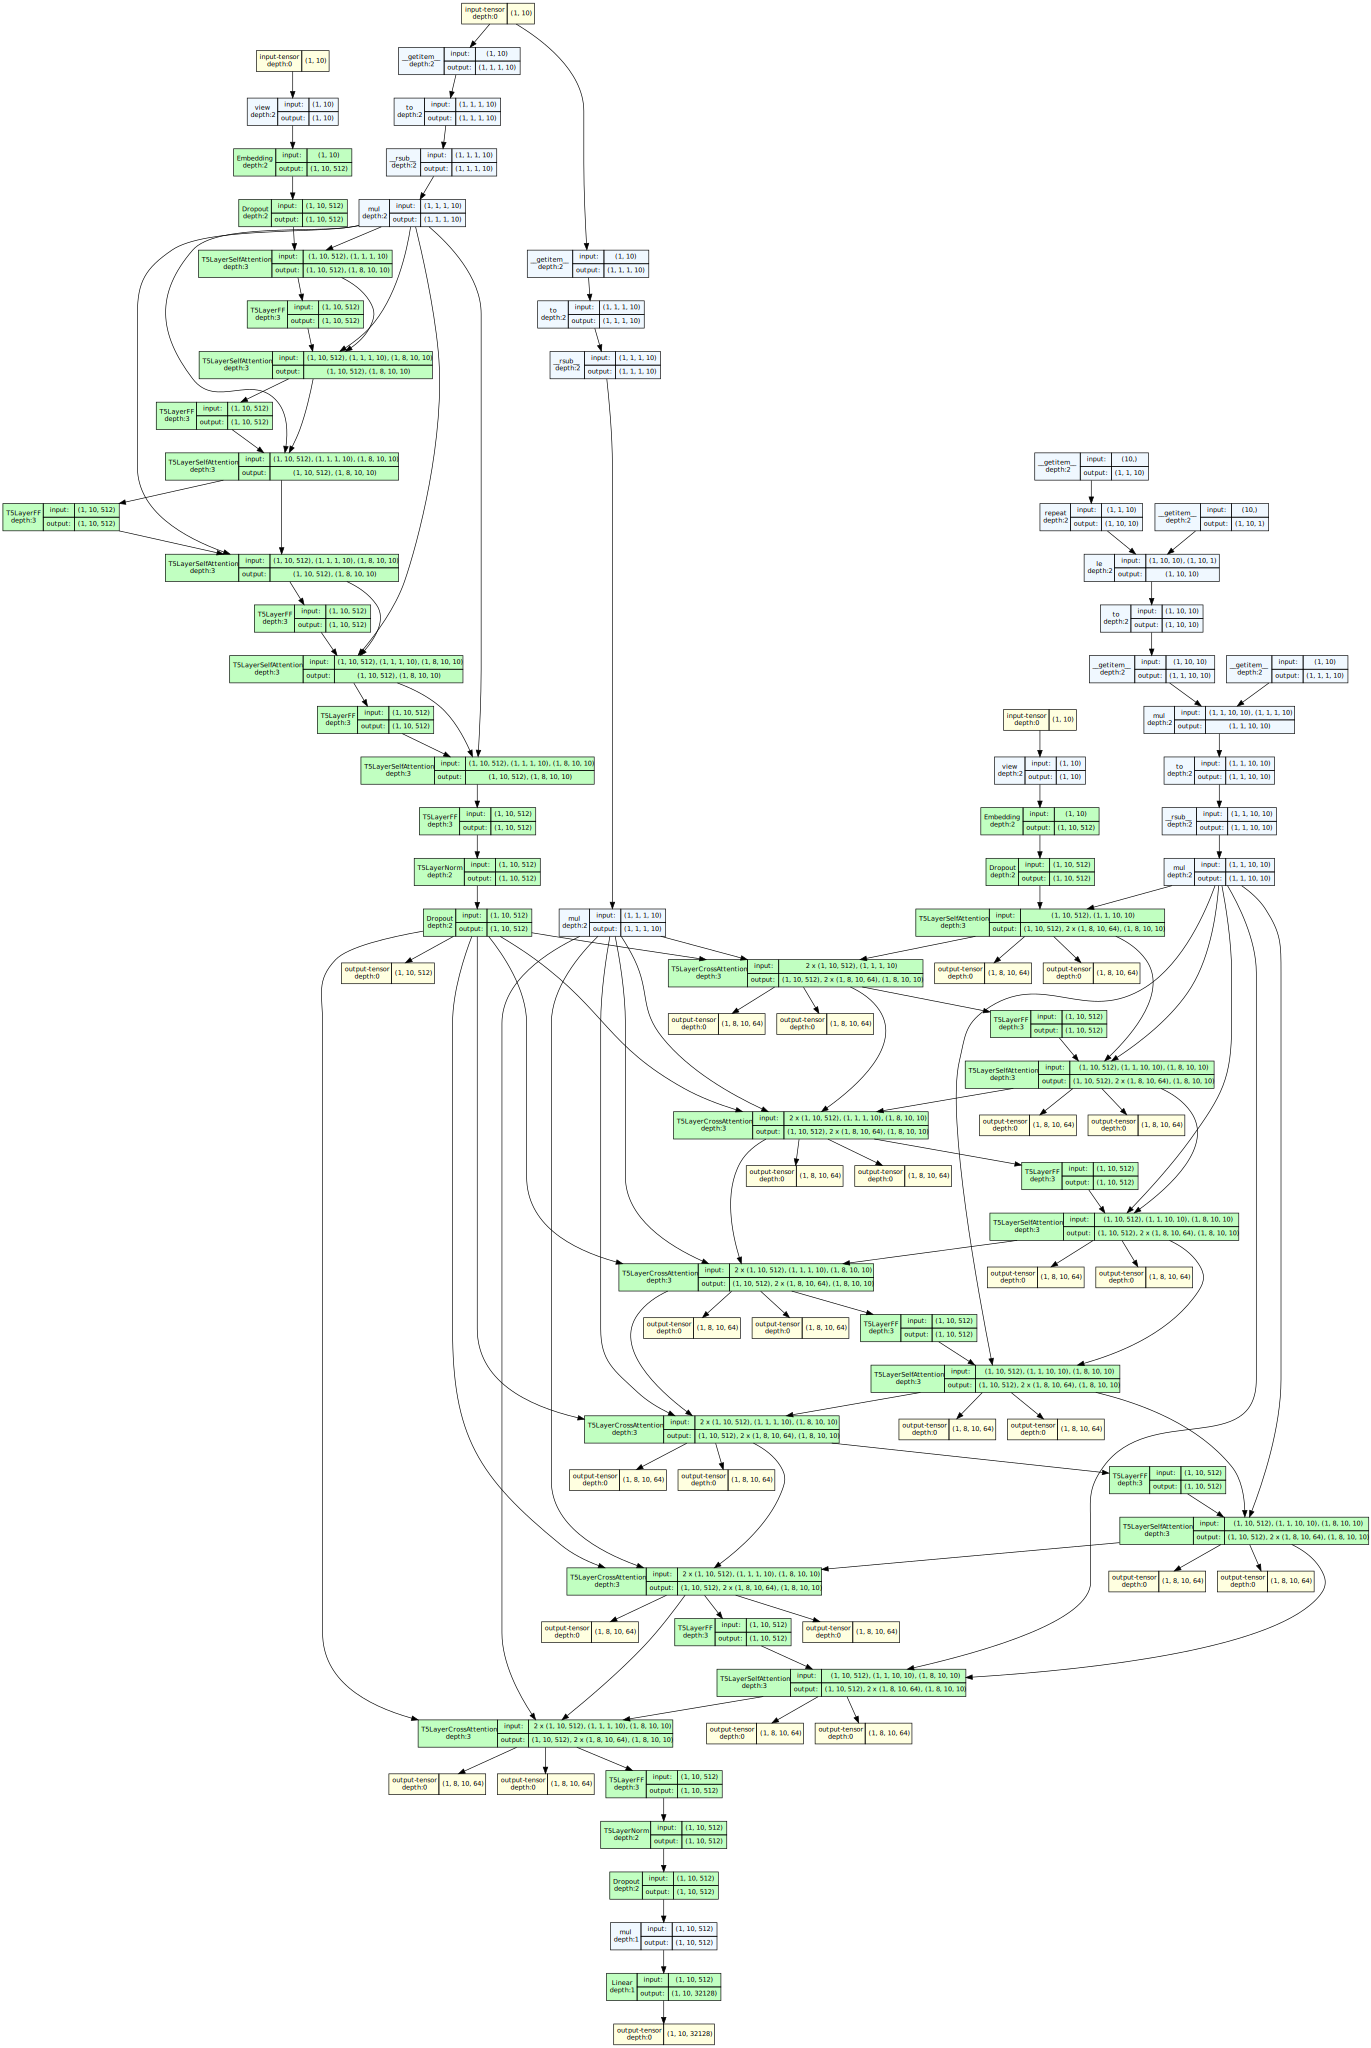

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

from torchview import draw_graph
tokens2 = tokens.copy()
tokens2['decoder_input_ids'] = tokens['input_ids']
g = draw_graph(model, tokens2, hide_inner_tensors=True)
g.visual_graph

# GPT

In [263]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

model = OpenAIGPTModel.from_pretrained("openai-gpt")

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [267]:
tokens = tokenizer(["""Where is the money, Lebowski?"""], return_tensors='pt')
out = model(**tokens)
out[0]

tensor([[[ 0.1906, -0.3876, -0.0546,  ...,  0.4045, -0.2542,  0.2221],
         [ 0.1347, -0.0751, -0.2874,  ..., -0.2186, -0.0825, -0.9387],
         [ 0.6768, -0.4743, -0.1264,  ..., -0.2225,  0.0109, -0.5900],
         ...,
         [ 0.7759, -0.5443,  2.4665,  ...,  1.2729, -0.2042, -0.0438],
         [ 0.8933, -0.4608,  0.8507,  ...,  0.9035, -0.2807, -1.1199],
         [ 0.5332, -0.3979,  0.2571,  ..., -0.2335, -0.1295, -0.4050]]],
       grad_fn=<ViewBackward0>)

In [270]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='openai-gpt')
generator("Where is the money, Lebowski?")

Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 50 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Where is the money, Lebowski? " he wanted to know the rest of the story. \n " i didn\'t think it would take that long. if you could only get on that plane and fly back to new jersey, you \'d be'}]

In [271]:
traced = tr_symbolic_trace(model)
module2graph2.make_gamma_hooks(model, traced, lambda: module2graph2.Gamma(1.0))

NotImplementedError: Model OpenAIGPTModel is not supported yet, supported models: AlbertForMaskedLM, AlbertForMultipleChoice, AlbertForPreTraining, AlbertForQuestionAnswering, AlbertForSequenceClassification, AlbertForTokenClassification, AlbertModel, AltCLIPModel, AltCLIPTextModel, AltCLIPVisionModel, BartForCausalLM, BartForConditionalGeneration, BartForQuestionAnswering, BartForSequenceClassification, BartModel, BertForMaskedLM, BertForMultipleChoice, BertForNextSentencePrediction, BertForPreTraining, BertForQuestionAnswering, BertForSequenceClassification, BertForTokenClassification, BertLMHeadModel, BertModel, BlenderbotForCausalLM, BlenderbotForConditionalGeneration, BlenderbotModel, BlenderbotSmallForCausalLM, BlenderbotSmallForConditionalGeneration, BlenderbotSmallModel, BloomForCausalLM, BloomForQuestionAnswering, BloomForSequenceClassification, BloomForTokenClassification, BloomModel, CLIPModel, CLIPTextModel, CLIPTextModelWithProjection, CLIPVisionModel, CLIPVisionModelWithProjection, ConvNextBackbone, ConvNextForImageClassification, ConvNextModel, DebertaForMaskedLM, DebertaForQuestionAnswering, DebertaForSequenceClassification, DebertaForTokenClassification, DebertaModel, DebertaV2ForMaskedLM, DebertaV2ForMultipleChoice, DebertaV2ForQuestionAnswering, DebertaV2ForSequenceClassification, DebertaV2ForTokenClassification, DebertaV2Model, DistilBertForMaskedLM, DistilBertForMultipleChoice, DistilBertForQuestionAnswering, DistilBertForSequenceClassification, DistilBertForTokenClassification, DistilBertModel, DonutSwinModel, ElectraForCausalLM, ElectraForMaskedLM, ElectraForMultipleChoice, ElectraForPreTraining, ElectraForQuestionAnswering, ElectraForSequenceClassification, ElectraForTokenClassification, ElectraModel, GPT2DoubleHeadsModel, GPT2ForSequenceClassification, GPT2ForTokenClassification, GPT2LMHeadModel, GPT2Model, GPTJForCausalLM, GPTJForQuestionAnswering, GPTJForSequenceClassification, GPTJModel, GPTNeoForCausalLM, GPTNeoForSequenceClassification, GPTNeoModel, GitVisionModel, HubertForCTC, HubertForSequenceClassification, HubertModel, LayoutLMForMaskedLM, LayoutLMForQuestionAnswering, LayoutLMForSequenceClassification, LayoutLMForTokenClassification, LayoutLMModel, LxmertForPreTraining, LxmertForQuestionAnswering, LxmertModel, M2M100ForConditionalGeneration, M2M100Model, MBartForCausalLM, MBartForConditionalGeneration, MBartForQuestionAnswering, MBartForSequenceClassification, MBartModel, MT5ForConditionalGeneration, MT5Model, MarianForCausalLM, MarianMTModel, MarianModel, MegatronBertForCausalLM, MegatronBertForMaskedLM, MegatronBertForMultipleChoice, MegatronBertForNextSentencePrediction, MegatronBertForPreTraining, MegatronBertForQuestionAnswering, MegatronBertForSequenceClassification, MegatronBertForTokenClassification, MegatronBertModel, MobileBertForMaskedLM, MobileBertForMultipleChoice, MobileBertForNextSentencePrediction, MobileBertForPreTraining, MobileBertForQuestionAnswering, MobileBertForSequenceClassification, MobileBertForTokenClassification, MobileBertModel, NezhaForMaskedLM, NezhaForMultipleChoice, NezhaForNextSentencePrediction, NezhaForPreTraining, NezhaForQuestionAnswering, NezhaForSequenceClassification, NezhaForTokenClassification, NezhaModel, OPTForCausalLM, OPTForQuestionAnswering, OPTForSequenceClassification, OPTModel, PLBartForCausalLM, PLBartForConditionalGeneration, PLBartForSequenceClassification, PLBartModel, PegasusForCausalLM, PegasusForConditionalGeneration, PegasusModel, ResNetBackbone, ResNetForImageClassification, ResNetModel, RobertaForCausalLM, RobertaForMaskedLM, RobertaForMultipleChoice, RobertaForQuestionAnswering, RobertaForSequenceClassification, RobertaForTokenClassification, RobertaModel, SegformerForImageClassification, SegformerForSemanticSegmentation, SegformerModel, Speech2Text2Decoder, Speech2Text2ForCausalLM, Speech2TextForConditionalGeneration, Speech2TextModel, SwinBackbone, SwinForImageClassification, SwinForMaskedImageModeling, SwinModel, T5ForConditionalGeneration, T5Model, TrOCRDecoder, TrOCRForCausalLM, ViTForImageClassification, ViTForMaskedImageModeling, ViTModel, Wav2Vec2ForCTC, Wav2Vec2ForMaskedLM, Wav2Vec2ForPreTraining, Wav2Vec2ForSequenceClassification, Wav2Vec2Model, XGLMForCausalLM, XGLMModel